# Exploratory Data Anaysis

Before we begin with the *EDA* we need to read the *metadata*. 

If there is not or it is incomplete (as is our current case) we will create or add after the *EDA*.

We need highlight that the analysis the data we will be have an economics approach, but it can apply any approach.

In order to track the transformations that we apply to our data, each time we apply these transformation we will save all files and will do commit (*snapshoot*) using git. This useful by reasons of *reproducibility* 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Data Source:

* [Principles of Econometrics - Data](http://www.principlesofeconometrics.com)

* [Wooldridge - Metadata](http://fmwww.bc.edu/ec-p/data/wooldridge/mroz.des)

  * It is a cross-sectional women's labor force participation data with 753 observations on 25 variables.
  * A short description of the meaning of the variables is above (metadata). But it is not enought.     
    e.g. $\text{lfp} = 1 \; \text{if the women belong labor force}, 0 \;\text{otherwise}$. This is our *target*, the variable we want to explain.

In [3]:
mroz = pd.read_csv('http://www.principlesofeconometrics.com/poe5/data/csv/mroz.csv')

In [4]:
print("(Records, Features):", mroz.shape)
print("Null: ", np.sum(np.sum(mroz.isnull())))

(Records, Features): (753, 25)
Null:  0


* We can see the structure of the data is *Homogeneous* (*structured*), that is, all of records have the same schema. And also the data is *tabular*, since the schema is simple. The later can be tested showing the *data type*. If it includes list type or array type this means the schema is complex.

In [5]:
print('Data types uniques: ', mroz.dtypes.unique())

Data types uniques:  [dtype('int64') dtype('float64')]


* Also we can see the data is cleanned (*there is not nulls*) so, we don't need to the stage of the *Cleasing Data*.

* This data can be taken as a *sample* or as the *population*. But almost always in a company, the data is the *population of customers*. So, the data will be considered as *population*. This *assumption* must point out in the metadata.

### Univariate and Multivariate

* Tools in order to analyze are $^{[1]}$:
  * Histogram or variations (like counts) to analyze the `categorical values` .
  
  *  For `numerical values`, we want to find the measures of central tendency (mean,
median, mode, and a few more) and dispersion (standard deviation, quartiles).

We begin the analysis with feature `experience` 

In [141]:
def plot_serie(s:pd.Series, bins = 30, title :str =  None):
    _, ax = plt.subplots()
    n_bins = int(np.log2(len(s)) + 1) if bins == 'sturges' else bins
    ax = s.plot(kind = 'hist', bins = n_bins, figsize = (10, 6), density  =True, ax = ax, alpha = 0.6)
    quantile = dict(s.quantile([0, 0.25, 0.5, 0.75, 1]))
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    
    for q in quantile:
        ax.text(quantile[q], 0, '|', color = (1,1,1, 0.7))
        ax.text(
            quantile[q], 
            np.multiply(np.ptp(ax.get_yticks()),0.05), 
            fr'$q$({(int(q*100))})', 
            color = (0,0,0, 1), ha = 'center', bbox=bbox_props)

    ax.set_title(title)
    return ax

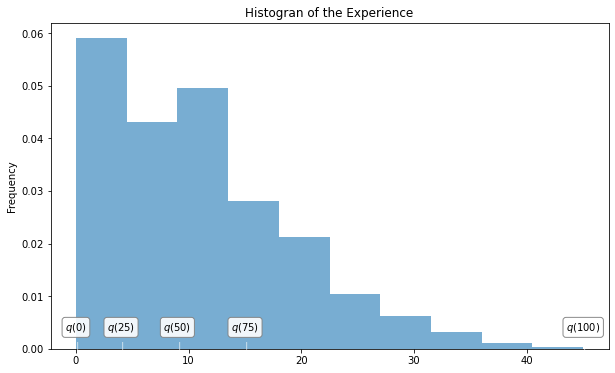

In [142]:
mroz_int64 = mroz.select_dtypes(include='int64').copy(deep= True)
plot_serie(mroz_int64.exper, bins='sturges', title='Histogran of the Experience'); plt.show()

* As we can see, the $75\%$ of the surveyed people (*woman*) have not reached the 15 years of experience in *labor force*.

* This rate increases at $87.9\%$ if the surveyed people (*woman*) don't belong to *labor force*. and reduce at $68\%$ if the *woman* don't.

In [8]:
def marginal_lfp(data, feat, q= 0.5):
    # get min, q_75, max
    data = data.copy(deep = True)
    feat_q = data[feat].quantile([0, q, 1])
    # create a new feature
    data[f'{feat}_q{q}'] = pd.cut(data[feat], bins=feat_q)
    # Table frequence
    cross = pd.crosstab(data['lfp'], data[f'{feat}_q{q}'])
    # Contingence table -> Marginalize at `lft`
    print('-> Contingence table \n-> Marginalize at `lft`:\n->',cross.divide(cross.sum(axis=1), axis='index'))

marginal_lfp(mroz_int64, 'exper', q= 0.5)

-> Contingence table 
-> Marginalize at `lft`:
-> exper_q0.5  (0.0, 9.0]  (9.0, 45.0]
lfp                                
0             0.649485     0.350515
1             0.375887     0.624113


Maybe the education of the father can be influded in women belong to *labor force*

In [9]:
marginal_lfp(mroz_int64, 'fathereduc', q= 0.5)

-> Contingence table 
-> Marginalize at `lft`:
-> fathereduc_q0.5  (0.0, 7.0]  (7.0, 17.0]
lfp                                     
0                  0.561905     0.438095
1                  0.553191     0.446809


* We don't see any difference in the education of the women's father if she belong to or not to *labor force*

* It is important to point out right away that aggregate functions `skip nulls`.

#### Kids

**Metadata**:

* *kidslt6*: 
  * Answer to the question: *How many kids less that 6 year do you have?*
  * Data Type: Integer
  * Data classification: Categorical
  * Range: 0 - 3, where 0 point out the women doesn't have kids and 3 point out the women have 3 kids.
  
* *kids618*: 
  * Answer to the question: *How many kids greater than 6 but less 18 year do you have?*
  * Data Type: Integer
  * Data classification: Categorical
  * Range: 0 - 8, where 0 point out the women doesn't have kids and 8 point out the women have 8 kids.
  

* We can see a women that belong to force labor has in average 0.22 less *kids (of age less than 6)* than a women that don't belong to force labor.

* If a women has *kids (of age between 6 and 18 years)* seems is not relevant for the explanation of if a women belongs to force labor or not

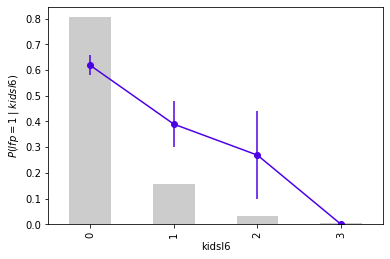

In [10]:
def plot_prob(feat:str):

    _, ax = plt.subplots()
    cross = mroz.groupby([feat])['lfp'].agg(['mean', lambda x :np.std(x)/np.sqrt(len(x))])
    cross.columns = ['MEAN', 'SE']
    color = (0.3, 0.0, 0.9)
    ax.errorbar(range(len(cross)), cross['MEAN'], 1.96*cross['SE'], color = color, fmt='-o')
    ax.set_xticks(range(len(cross))); ax.set_xticklabels(labels = cross.index)
    ax.set(xlabel = feat, ylabel  = rf'$P(lfp = 1 \;|\;{feat})$')

    mroz_feat = mroz[feat].value_counts(normalize=True)
    mroz_feat.plot(kind = 'bar', color = (0, 0, 0, 0.2), ax = ax)
    
    return ax

plot_prob(feat = 'kidsl6');plt.show()

* We can see the probability a women belong to force labor decreases as the women had more kids (of the age less 6 years). If a women has 3 kids (of the age less 6 years) the probability belong to force labor is almost zero.

* The standar error plotted above increase as the women had more kids, but this is the effect of the size by each group (0, 1, 2, 3).

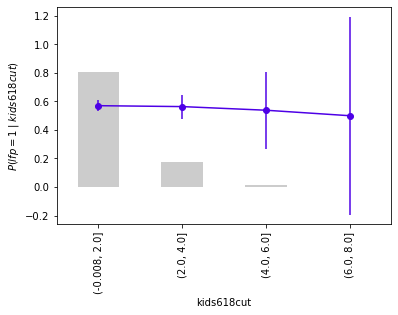

In [11]:
mroz['kids618cut'] = pd.cut(mroz['kids618'], bins = 4)
plot_prob(feat = 'kids618cut');plt.show()

* We can see the probability of a women belong to force labor don't change as the amount of kids increases.

* As above, the standar error plotted increase as the women had more kids, but this is the effect of the size of teh caterories 6, 7 and 8.



#### Age

**Metadata**

* Age:

  * Answer to the question: *How old are you?*
  * Data Type: Integer
  * Data classification: Categorical
  * Range: 33 - 60
  * Syntatic domain: years 

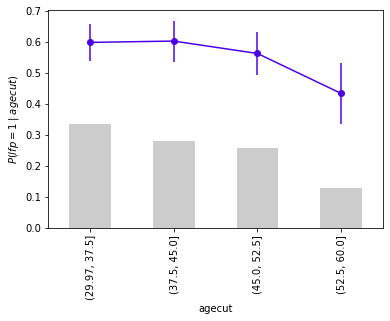

In [12]:
mroz['agecut'] = pd.cut(mroz.age, bins = 4)
plot_prob(feat = 'agecut');plt.show()

* As we hope, the probability of a women belong to force labor decrease as she is older. But if we compare this decresing with the effect of the kidsl6, the effect age on the probability of a women belong to force labor is less.

#### Education

**Metadata**

* Education:
  * Data Type: Integer
  * Data classification: Categorical
  * Range: 4 - 17
  * Syntatic domain: years 


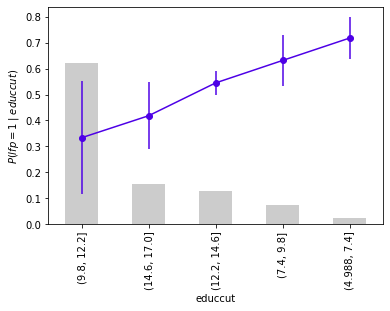

In [13]:
mroz['educcut'] = pd.cut(mroz.educ, bins = 5)
plot_prob(feat = 'educcut');plt.show()

#### Join Effects

* *Age* and *Kids*
  
  The following analysis join the effects both Age and the Kids. 

Text(0.5, 0.98, "Women's Force Labor Supply Rate\n by Range of Educ Years")

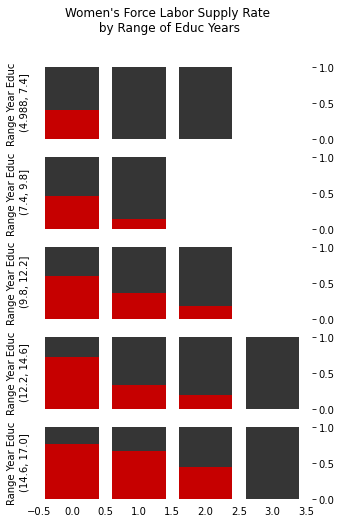

In [14]:
mroz_rates = mroz.pivot_table(index='kidsl6', columns='educcut', values='lfp')

fig, ax = plt.subplots(5, sharex="all", figsize = (5, 8))

_educcut = mroz_rates.columns
for (i, _educ) in enumerate(_educcut):
    _rr_vals = mroz_rates[_educ].values

    ax[i].bar(range(0, 4), _rr_vals, color="#c60000")
    ax[i].bar(range(0, 4), 1 - _rr_vals, bottom=_rr_vals, color="#353535")
    ax[i].set_ylabel(f'Range Year Educ \n{_educ}')
    for spine in ['left', 'right', 'top', 'bottom']:
        ax[i].spines[spine].set_visible(False)
    ax[i].yaxis.tick_right()
    ax[i].xaxis.set_ticks_position("none")

fig.suptitle("Women's Force Labor Supply Rate\n by Range of Educ Years")

* The plot showed above highlights what we already know, but this provides us a bit more information. For instance, the rate of the women's force labor supply increases if we join the two effects (*Kids* and *Educ*) than we would be analyzing the effects by separeted. 
  
  * *Join*: $0.76$ (*Educ* is in $(14.6, 17.0]$ and *Kid* is equal $0$) 
  * *Educ*: $0.7$ (*Educ* is in $(14.6, 17.0]$)
  * *Kids*: $0.6$ (*Kid* is equal $0$)

## Family and Husband

The effect of the women in the force labor supply on both *Family Income* and *Husband Wage*

**Metadata**
* Family Income
  * Data Type: Float
  * Syntatic domain: Dollar U.S.  
  * Semantic: Annual

In [15]:
from scipy.stats import skew, kurtosis

def summary_stats(data:pd.DataFrame, feat:str):
    data_feat = data[feat].copy(deep=True)
    stats_feat = [
        skew(data_feat), kurtosis(data_feat), np.std(data_feat), 
        np.mean(data_feat), np.median(data_feat), np.median(data_feat)]
        
    stats_name = ['Skew', 'Kurtosis', 'Std', 'Mean', 'Median']
    for stat_feat, stat_name in zip(stats_feat, stats_name):
        print('->',stat_name.ljust(8), round(stat_feat, 2))

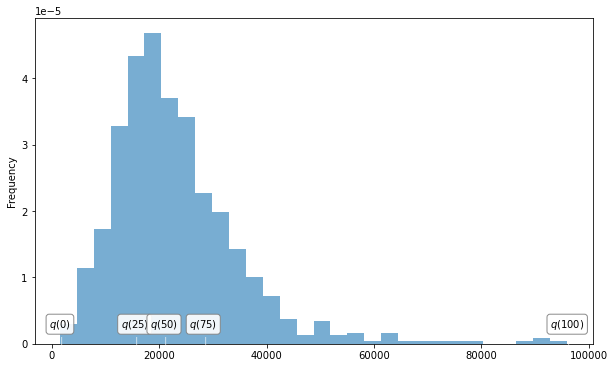

-> Skew     1.9
-> Kurtosis 6.48
-> Std      12182.1
-> Mean     23080.59
-> Median   20880.0


In [143]:
plot_serie(mroz['faminc']);plt.show()
summary_stats(mroz, 'faminc')

* The stadar deviation compute the average deviation between the values and its mean that in this case is $\$12,190$

* The *standard deviation*  are affected by *outliers*, so sometimes the `MAD` (*Median Absolute Deviation*) is calculated too.

$$\text{MAD}(x_i) = \text{median}(|x_i − \text{median}_i(x_i)|)$$

In [17]:
def mad(data, feat):
    mad = np.median(np.abs(data[feat] - np.median(data[feat])))
    print('-> MAD:', mad)
    return 

mad(mroz, 'faminc')

-> MAD: 6124.0


But the good of the variance is we can descompose in within and between, like that.

In [127]:
def within_between(data:pd.DataFrame, feat:str, q:list = [0, .25, 0.5, .75, 1]):
    
    def average(x):
        return sum(x)/len(x)

    def variance(x):
        return average((x - average(x))**2)

    data = data.copy(deep=True)
    quantiles = data[feat].quantile(q)
    data[f'{feat}_q'] = pd.cut(data[feat], bins = quantiles)

    stats = data.groupby(f'{feat}_q')[feat].agg([variance, average, 'size'])

    n = len(data[feat])
    µ = average(stats['average'])

    between = (1/n)*(np.sum(stats['size'] * (stats['average'] - µ)**2))
    within = (1/n)*(np.sum(stats['size'] * stats['variance']))

    total = variance(data[feat])
    print('-> Between Variance: {:.2%}'.format(between/total))
    print('-> Within Variance: {:.2%}'.format(within/total))

within_between(mroz,'faminc') #, q=[0, 0.5, 1])

-> Between Variance: 70.76%
-> Within Variance: 28.82%


* The total variance is explained in $70\%$ by the variance between the groups, this is an evidence of the inequality in the *family income* in general.

* On the order hand, we can show the effects of whether the women belong to *labor force*

* we can can see this effects is not enought. An example is if the a women don't belong to *labor force* the probabiliby of the *family income* is in range $[\$15,000, \$20,880]$ reaches $55\%$ (increasing only $5\%$).

In [30]:
def quantiles(data:pd.DataFrame, feat:str, q:list = [0, .25, 0.5, .75, 1]):

    data = data.copy(deep=True)
    quantiles = data[feat].quantile(q)
    data[f'{feat}_q'] = pd.cut(data[feat], bins = quantiles)
    cross = pd.crosstab(data['lfp'],data[f'{feat}_q'])

    return cross.div(cross.sum(axis=1), axis='index')

quantiles(mroz,'faminc', q=[0, 0.5, 1])

faminc_q,"(1500.0, 20880.0]","(20880.0, 96000.0]"
lfp,,
0,0.558642,0.441358
1,0.455607,0.544393


In [168]:
quantiles(mroz,'faminc')

faminc_q,"(1500.0, 15428.0]","(15428.0, 20880.0]","(20880.0, 28200.0]","(28200.0, 96000.0]"
lfp,,,,
0,0.314815,0.243827,0.234568,0.20679
1,0.200935,0.254673,0.261682,0.28271


* As we can see the effects of the participation of women in the labor market on family income is positive for the families with low incomes.(increase $6\%$)

* Due to the fact that the quantiles 0, 0.25, 0.5 and 0.75 have increased simultaneously we can infer the mean has increased as well. This mean a family can increses its income if the women can supply her the workforce.

### Surprise

* The surprise is the inverse of the probability, and the entropy is the expectation of the suprise.

$$\text{Entropy} = - \sum p(x) \text{log}_2(p(x))$$

In [176]:
def entropy(x):
    return -np.sum(x*np.log2(x))

prob = quantiles(mroz,'faminc', q=[0, 0.25, 0.5, 0.75 ,1])

print('Entropy given lfp = 0 ',entropy(prob.values[0,:]))
print('Entropy given lfp = 1 ',entropy(prob.values[1,:]))

Entropy given lfp = 0  1.9822681177936774
Entropy given lfp = 1  1.989137399284925


The results show that the entropy condicioned on $\text{lfp} = 0$ is the same that if we condicione on $\text{lfp} = 1$, thats mean they have the same variance.

## Bootsraping Analysis

*P-values* using Bootstraping

* Assuming that the mean $μ_1$ is the average of the family income if the wife doesn't supply in labor market and assuming that the mean $μ_0$ is the average of the family income if the wife does supply in labor market.

* So we have $Δ = μ_1 − μ_0$.

* We consider the one-sided hypotheses given by

$$H_0 : Δ = 0 \; \text{versus} \; H_1 : Δ > 0$$

* That is, our null hypothesis means there is not difference between the family incomes if the wife supply in labor market.

* Recall we only have a sample, this is used for bootstraping

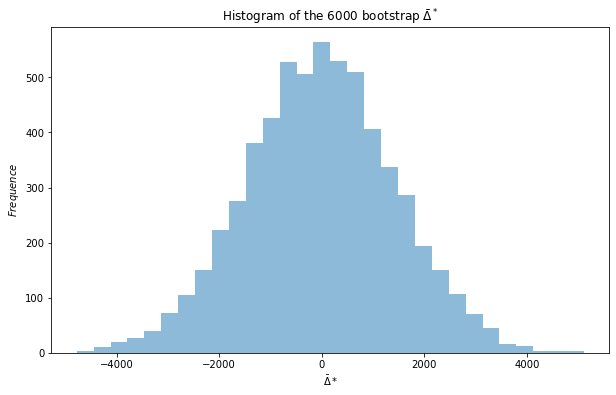

 > P-value:15.53%


In [296]:
# Δ = μ_1 − μ_0
# H0: Δ = 0, Ha: Δ > 0

def anaysis_boots(feat, B, data):
    cross = dict(data.groupby('lfp')[feat].mean())
    Δ = cross[1] - cross[0]

    data_grouped = data.groupby('lfp')

    def boots_sample():
        boots_means = {}
        for g, group_data in data_grouped:
            z = (group_data[feat] - Δ) if g == 1 else (group_data[feat])
            sample = np.random.choice(z, size= len(group_data[feat]), replace=True)
            boots_means[g] = np.mean(sample)
        return boots_means[1] - boots_means[0]

    boots_diff = np.array([boots_sample() for _ in range(B)])

    _, ax = plt.subplots(figsize = (10, 6))

    ax.hist(boots_diff, bins=30, density=False, alpha = 0.5)
    ax.set(xlabel = r'$\bar{Δ}*$', ylabel = '$Frequence$', title = f'Histogram of the {B} bootstrap '+r'$\bar{Δ}^*$')
    
    plt.show()
    p_value = sum(boots_diff>=Δ)/len(boots_diff)
    return ax, p_value, Δ

# Features
feat = 'faminc'
# Sampling by Bootstraping
B = 6000
# Take a sample
mroz_sample = mroz.groupby('lfp', group_keys=False).apply(lambda x:x.sample(100)) # random_state=123
data = mroz_sample.copy()

ax, p_value, Δ = anaysis_boots(feat, B, data);plt.show()
print(f' > P-value:{p_value:.2%}')

* The result of this experiment point out there is difference between the family incomes whether the wife supply in labor market or not.

* p-value indiques if we don't reject the null hypothesis, the probability of commit the error *type I* is $12.00\%$

* So, we can say the effect of the women on family income is enought to reject the $H_0$.

## What if we took other sample?

* The purpose of this apart is computing the mean of the p-values in order to see the behaviour of the p-values by several samples of the population and test the robutness if the p-value.

In [286]:
def anaysis_boots(feat, B, data):
    cross = dict(data.groupby('lfp')[feat].mean())
    Δ = cross[1] - cross[0]

    data_grouped = data.groupby('lfp')

    def boots_sample(): 
        boots_means = {}
        for g, group_data in data_grouped:
            z = (group_data[feat] - Δ) if g == 1 else (group_data[feat])
            sample = np.random.choice(z, size= len(group_data[feat]), replace=True)
            boots_means[g] = np.mean(sample)

        return boots_means[1] - boots_means[0]

    boots_diff = np.array([boots_sample() for _ in range(B)])
    p_value = sum(boots_diff>=Δ)/len(boots_diff)
    
    return p_value

In [287]:
feat = 'faminc'
B = 6000

def p_value_sampling():
    mroz_sample = mroz.groupby('lfp', group_keys=False).apply(lambda x:x.sample(100))
    data = mroz_sample.copy()
    p_value = anaysis_boots(feat, B, data)
    return p_value

In [288]:
p_values = (p_value_sampling() for _ in range(20))

In [289]:
sum(p_values)/20

0.12847499999999998

* The mean computed point out the robutness we hoped. 

* The mean of the p-values is closed at p-value computed by only sample.

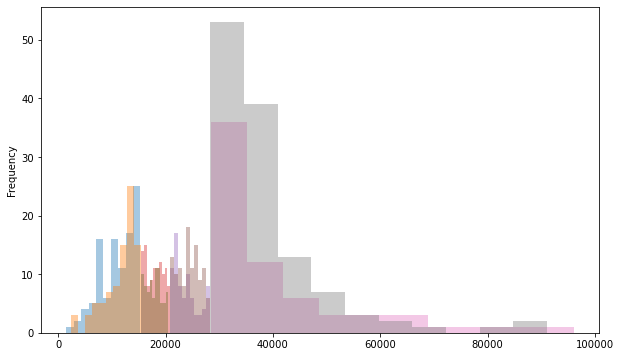

In [284]:
mroz['faminc_quantile'] = pd.cut(mroz.faminc, mroz.faminc.quantile([0, 0.25, 0.5, .75, 1]), include_lowest=True)

for _, group_by_quantile in mroz.groupby('faminc_quantile'):
    for _, group_by_lfp in group_by_quantile.groupby('lfp'):
        group_by_lfp.faminc.plot(kind = 'hist', alpha = 0.4, bins = 10, figsize = (10, 6))

## References

* Robert Hogg, Joseph McKean, Allen Craig - Introduction to Mathematical Statistics - Pages 311- 312.

* Chase Coleman, Spencer Lyon, and Jesse Perla - [QuanEcon](https://datascience.quantecon.org/applications/recidivism.html)

* Antonio Badia - SQL for Data Science. Data-Centric Systems and Applications.Springer Cham. Louisville, KY, USA. .July 2020 - Pages 165 - 166.

* $[1]$ Antonio Badia - SQL for Data Science. Data-Centric Systems and Applications.Springer Cham. Louisville, KY, USA. .July 2020 - Page 106.
